# Test SimOOS Oracle

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
1,1,1,1,1,3
4,1,1,1,1,3
5,1,1,1,1,1
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12950,4,4,3,1,1
12951,4,4,3,2,2
12953,4,4,3,2,1
12954,4,4,3,2,2


## Drop for debug and testing

In [6]:
all_contexts = all_contexts.drop(columns=['form', 'children'])

In [7]:
all_rewards

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [8]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [9]:
all_rewards.shape[0]

10000

In [10]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [11]:
stationarity_regions = [
    slice(0, all_contexts.shape[0]),
]

In [12]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [13]:
change_point_values

[1, 10000]

In [14]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3405, 0.3372, 0.3223])

In [15]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [16]:
new_contexts.shape, new_rewards.shape

((10000, 3), (10000, 3))

In [17]:
(new_rewards == all_rewards).all()

True

## Plot expected reward

Min expected reward for arm 1: 0.3405
Min expected reward for arm 2: 0.3372
Min expected reward for arm 3: 0.3223


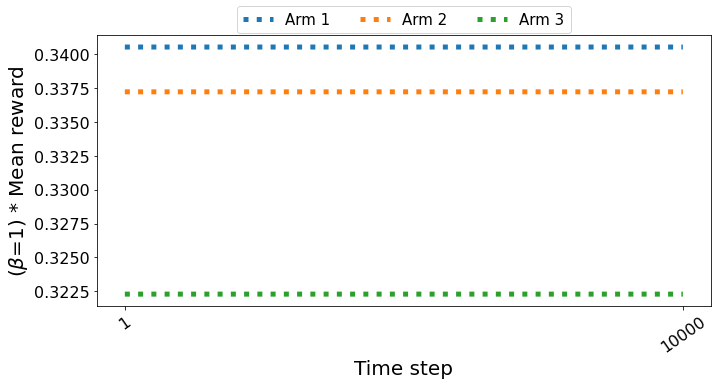

In [18]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [19]:
cost_change_points = []#[3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [20]:
cost_means_range = [0.05, 0.08]

In [21]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [22]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [23]:
interval_means

[array([0.0612362 , 0.07852143, 0.07195982])]

In [24]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [25]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

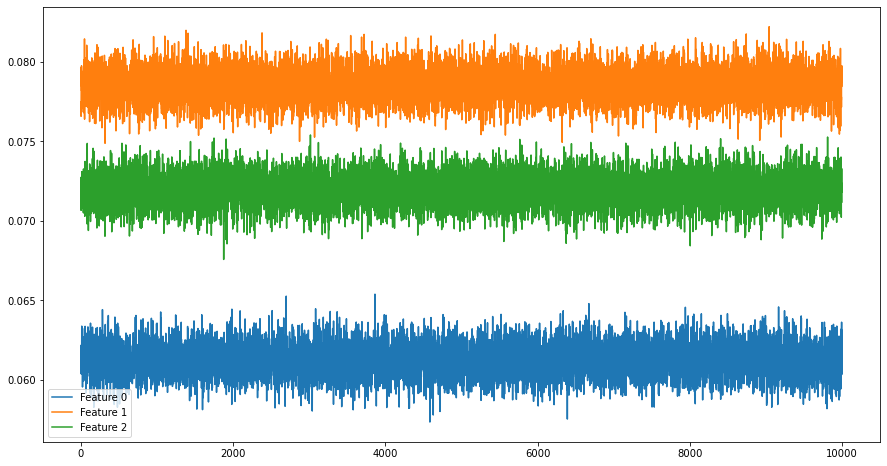

In [26]:
plot_costs(get_costs(), new_contexts.shape[0])

In [27]:
costs_obj = get_costs()

In [28]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [29]:
costs_vector.shape

(10000, 3)

## Save mean costs for plotting

In [30]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [31]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

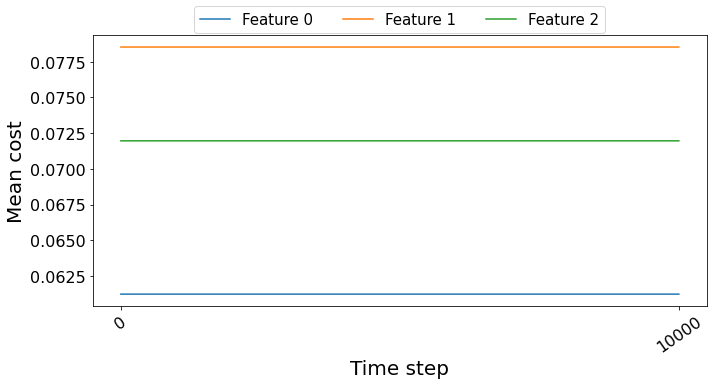

In [32]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [33]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: 0.12171807574746663
Min expected gain for arm 2: 0.1184180757474666
Min expected gain for arm 3: 0.10351807574746658


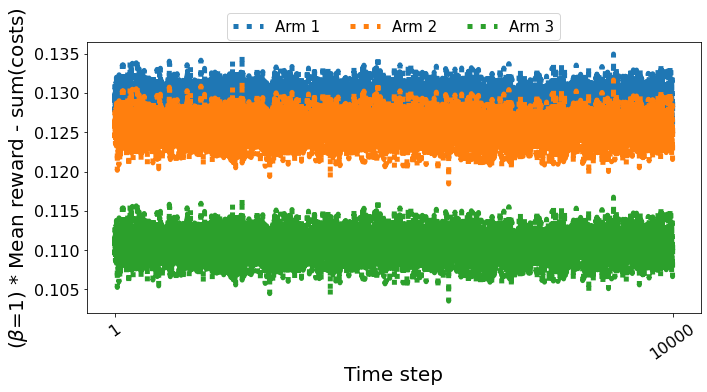

In [34]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [35]:
def plot_gains(gain_dict, reward_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4)
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

## Testing SimOOS oracle

In [36]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 1

In [37]:
np.random.seed(42)

In [38]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_random[i, :] = gain_random
    
gain_random = np.mean(gains_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3280.0
	Total reward: 3280.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3280.0


In [39]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_egreedy[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3300.0
	Total reward: 3300.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3300.0


In [40]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_ucb[i, :] = gain_ucb

gain_ucb = np.mean(gains_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5325.0
	Total reward: 5325.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5325.0


In [41]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_linucb[i, :] = gain_linucb

gain_linucb = np.mean(gains_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 5773.580269865388
	Total reward: 7891.0
	Total cost: 2117.419730134605
Execution time: 0.4s
Average gain: 5773.580269865388


In [42]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains_pslinucb[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5490.580269865399
	Total reward: 7608.0
	Total cost: 2117.419730134605
Execution time: 0.5s
Average gain: 5490.580269865399


In [122]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.005,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos

gain_simoos = np.mean(gains_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0010991096496582031 seconds
Trial 0, time 2022-05-24 16:56:32.482121
Trial 500, time 2022-05-24 16:56:35.152623
Trial 1000, time 2022-05-24 16:56:35.319070
Trial 1500, time 2022-05-24 16:56:35.445611
Trial 2000, time 2022-05-24 16:56:35.605716
Trial 2500, time 2022-05-24 16:56:35.733826
Trial 3000, time 2022-05-24 16:56:35.796696
Trial 3500, time 2022-05-24 16:56:36.871739
Trial 4000, time 2022-05-24 16:56:37.218606
Trial 4500, time 2022-05-24 16:56:37.306921
Trial 5000, time 2022-05-24 16:56:37.373773
Trial 5500, time 2022-05-24 16:56:37.463315
Trial 6000, time 2022-05-24 16:56:37.960910
Trial 6500, time 2022-05-24 16:56:38.010285
Trial 7000, time 2022-05-24 16:56:38.165141
Trial 7500, time 2022-05-24 16:56:38.489751
Trial 8000, time 2022-05-24 16:56:38.574259
Trial 8500, time 2022-05-24 16:56:38.656864
Trial 9000, time 2022-05-24 16:56:38.718443
Trial 9500, time 2022-05-24 16:56:38.804923
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 5512.478947935835
	Total reward: 7254.0

In [123]:
costs_vector[0]

array([0.06154092, 0.07748145, 0.07271027])

In [124]:
gains_simoos_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos_oracle = algorithms.SimOOS_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_vector=costs_vector[0],
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos_oracle = evaluation.evaluate_on_synthetic_data(
            p_simoos_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos_oracle[i, :] = gain_simoos_oracle

gain_simoos_oracle = np.mean(gains_simoos_oracle, axis=0)
print(f"Average gain: {gain_simoos_oracle[-1]}")

Took 0.06871700286865234 seconds
Trial 0, time 2022-05-24 16:56:46.423683
Trial 500, time 2022-05-24 16:56:46.427909
Trial 1000, time 2022-05-24 16:56:46.432220
Trial 1500, time 2022-05-24 16:56:46.436717
Trial 2000, time 2022-05-24 16:56:46.441055
Trial 2500, time 2022-05-24 16:56:46.445347
Trial 3000, time 2022-05-24 16:56:46.449748
Trial 3500, time 2022-05-24 16:56:46.454025
Trial 4000, time 2022-05-24 16:56:46.458304
Trial 4500, time 2022-05-24 16:56:46.462483
Trial 5000, time 2022-05-24 16:56:46.466852
Trial 5500, time 2022-05-24 16:56:46.471102
Trial 6000, time 2022-05-24 16:56:46.475392
Trial 6500, time 2022-05-24 16:56:46.479590
Trial 7000, time 2022-05-24 16:56:46.484023
Trial 7500, time 2022-05-24 16:56:46.488276
Trial 8000, time 2022-05-24 16:56:46.492931
Trial 8500, time 2022-05-24 16:56:46.497112
Trial 9000, time 2022-05-24 16:56:46.501458
Trial 9500, time 2022-05-24 16:56:46.505706
SimOOS-Oracle (beta=1)
Beta = 1
Total gain: 6554.501701495357
	Total reward: 7274.0
	Total 

In [ ]:
p_simoos

In [128]:
p_simoos.feature_values

defaultdict(list, {0: [1, 2, 3], 1: [1, 2], 2: [1, 2, 3]})

In [129]:
p_simoos.all_feature_counts

array([3., 2., 3.])

In [130]:
import algorithms.utilities as uts

In [144]:
uts.state_extract(
    p_simoos.feature_values,
    p_simoos.all_feature_counts,
    np.array([3, 2, 3]),
    np.array([1,1,1])
)

17

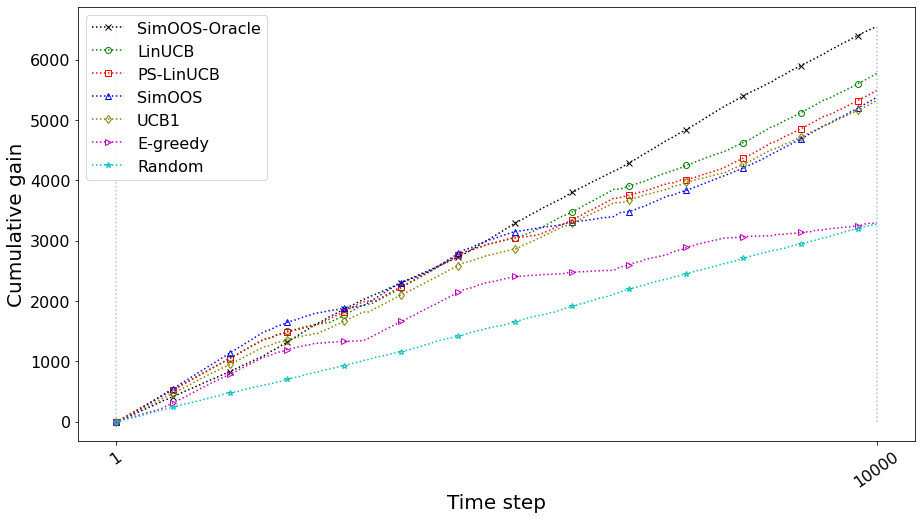

In [106]:
plot_gains(
    {
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'SimOOS-Oracle': gain_simoos_oracle,
    },
    reward_change_points=change_point_values,
)
